In [1]:
%%capture
%run utils.ipynb
import warnings
warnings.filterwarnings("ignore")
import time as t

Most of the utility functions are implemented in 'utils.ipynb'. 

# Data

S&P500 call options with different strike prices and maturities. 
* Sheets: different maturities (total 12)
* Columns: different strike prices
* Rows: time series of price evolution

In addition
* 1st column: days to maturity
* 3rd last column: spot price of S&P500 index (1000 units)
* 2nd last column: riskless interest rate

Note: prices of call are per 1000 units (as are spot prices for underlying)

In [2]:
xls = pd.ExcelFile('isx2010C.xls')
isx15012010C = pd.read_excel(xls, 'isx15012010C')
isx15012010C.rename(columns={isx15012010C.columns[0]:'days_to_mat',isx15012010C.columns[48]:'sp500_spot',isx15012010C.columns[49]:'rf'},inplace=True)

For example data for call option maturing at 15.01.2010

In [3]:
isx15012010C.head()

,days_to_mat,340,345,350,355,360,365,370,375,380,...,540,545,550,555,560,565,570,sp500_spot,rf,date
0,86,152.20,NaN,NaN,NaN,132.60,NaN,NaN,NaN,113.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,491.34,0.11,21.9.2009
1,85,155.05,NaN,NaN,NaN,135.35,NaN,NaN,NaN,115.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,494.35,0.11,22.9.2009
2,84,152.40,NaN,NaN,NaN,132.70,NaN,NaN,NaN,113.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.36,0.11,23.9.2009
3,83,147.00,NaN,NaN,NaN,127.25,NaN,NaN,NaN,108.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,486.99,0.11,24.9.2009
4,82,145.55,NaN,NaN,NaN,125.95,NaN,NaN,NaN,106.75,...,3.8,NaN,NaN,NaN,1525.0,NaN,NaN,484.11,0.11,25.9.2009


# Hedging

The fundamental idea of hedging is to immunize the current position in derivative instruments against changes in the underlying asset. Hedging is set up by taking an opposite position in the underlying (i.e. long call, short asset). The size of the hedging positon is dependent on **the hedging strategy** used.

Various hedging strategies are considered below.

### Accuracy of hedging

Hedging strategy can be measured by the average accuracy of the hedge. Let $P_t$ be the derivative portfolio and $R_t$ the replicating (hedge) portfolio.

$$MSE=\frac{1}{N}\sum_{i=1}^N\big(dP_i-dR_i\big)^2$$

# Delta hedging (single option)

Delta hedging is set up as following

$$P_t=C_t-\Delta_t S_t$$

that is, portfolio $P_t$ consists being long call ($C_t:=$ price of an call at $t$) and short $\Delta$-units of the underlying ($S_t:=$ price of the underlying at $t$).

Now at time $t=0$, we form the portfolio

$$P_0=C_0-\Delta_0 S_0$$

Given our **rehedging frequency** k, the portfolio is rehedged. That is new $\Delta_{0+k}$ is calculated at time $t=k$ and corresponding portfolio $P_{0+k}$ is formed. Note: Variations in $C_t$ and $S_t$ are stochastic.

Delta is calculated by solving **implied volatility** from $C_t$ and using this to compute $\Delta_t$

### Data

Consider an at-the-money (ATM) option, maturing at 15.01.2010. As suggested in the assignment, let $t_0=$ 45 days to maturity.

In [4]:
isx_m45 = isx15012010C[isx15012010C.shape[0]-45:].reset_index()
sp500_spot = isx_m45.iloc[0]['sp500_spot'] # S&P500 spot
sp500_spot

516.09

Since at $t_0$: $S_0=516.09$, call with $E=515$ is closest we can get to ATM. However, price series for this option is not complete (consists NaN values). Hence $E=520$ is chosen, which is in-the-money (ITM).

In [5]:
isx_m45_E520 = isx_m45[['days_to_mat',520,'sp500_spot','rf']]
isx_m45_E520.head()

,days_to_mat,520,sp500_spot,rf
0,45,13.3,516.09,0.07
1,44,13.8,516.54,0.07
2,43,10.2,510.35,0.07
3,42,9.5,508.79,0.04
4,41,11.6,516.00,0.04


How did the underlying asset (S&P500 index) behave during the run time of the option?

Text(0, 0.5, 'Spot')

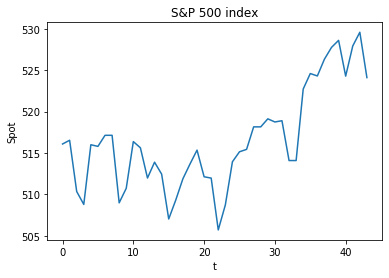

In [6]:
plt.plot(isx_m45_E520['sp500_spot'])
plt.title('S&P 500 index')
plt.xlabel('t')
plt.ylabel('Spot')

### Results (isx15012010C, $E=520$)

Solve implied volatility for each time step $t$.

In [7]:
# Rowwise computations of implied vola and delta
def implied_vola_rows(E,row):  return solve_implied_vola(row[E],row['sp500_spot'],E,row['days_to_mat'],row['rf'])
def delta_rows(E,row): return delta_call(row['sp500_spot'],E,row['days_to_mat'],row['rf'],row['implied_vola='+str(E)])

In [8]:
isx_m45_E520['implied_vola=520'] = isx_m45_E520.apply(lambda row: implied_vola_rows(520,row), axis=1)

Solve delta for each time step $t$.

In [9]:
isx_m45_E520['delta=520'] = isx_m45_E520.apply(lambda row: delta_rows(520,row), axis=1)
isx_m45_E520_general = isx_m45_E520 # dataframe for general results

Set rows for corresponding rehedging frequency. Here rehedging frequency $k=2$.

In [11]:
isx_m45_E520['delta_freq'] = set_rehedge_freq(2,isx_m45_E520['delta=520']) # rehedging frequency = 2
isx_m45_E520['hedge_pos'] = isx_m45_E520.apply(lambda row: row['sp500_spot']*row['delta_freq'],axis=1)
isx_m45_E520['change_P'] = isx_m45_E520[520].diff()
isx_m45_E520['change_R'] = isx_m45_E520['hedge_pos'].diff()
isx_m45_E520['MSE'] = isx_m45_E520.apply(lambda row: (row['change_P']-row['change_R'])**2,axis=1)

In [ ]:
isx_m45_E520.head()

In [ ]:
isx_m45_E520['MSE'].sum()/isx_m45_E520['MSE'].count() # Average hedging (square) error

Delta hedging isx15012010C, $E=520$ with rehedging frequency $k=2$: $MSE=14.24$

With different rehedging frequencies:

$k=3$

In [ ]:
isx_m45_E520['delta_freq'] = set_rehedge_freq(3,isx_m45_E520['delta'])
isx_m45_E520[0:7]

In [ ]:
isx_m45_E520['hedge_pos'] = isx_m45_E520.apply(lambda row: row['sp500_spot']*row['delta_freq'],axis=1)
isx_m45_E520['change_P'] = isx_m45_E520[520].diff()
isx_m45_E520['change_R'] = isx_m45_E520['hedge_pos'].diff()
isx_m45_E520['MSE'] = isx_m45_E520.apply(lambda row: (row['change_P']-row['change_R'])**2,axis=1)
isx_m45_E520['MSE'].sum()/isx_m45_E520['MSE'].count()

To generalize the results, lets plot $MSE$ as a function of rehedging frequency $k$ for isx15012010C, $E=520$.

In [ ]:
def MSE_for_freq_strike(E,k,data):
    data['delta_freq'] = set_rehedge_freq(k,data['delta='+str(E)])
    data['hedge_pos']  = data.apply(lambda row: row['sp500_spot']*row['delta_freq'],axis=1)
    data['change_P']   = data[E].diff()
    data['change_R']   = data['hedge_pos'].diff()
    data['MSE']        = data.apply(lambda row: (row['change_P']-row['change_R'])**2,axis=1)
    return data['MSE'].sum()/isx_m45_E520['MSE'].count() 

In [ ]:
plt.plot(range(1,15),[MSE_for_freq_strike(520,x,isx_m45_E520_general) for x in range(1,15)])
plt.title("isx15012010C, E=520")
plt.ylabel("MSE")
plt.xlabel("Rehedging frequency")

### Results (isx15012010C, $E=360$)

In [ ]:
isx_m45_E360 = isx_m45[['days_to_mat',360,'sp500_spot','rf']]

In [ ]:
isx_m45_E360['implied_vola=360'] = isx_m45_E360.apply(lambda row: implied_vola_rows(360,row), axis=1)
isx_m45_E360['delta=360'] = isx_m45_E360.apply(lambda row: delta_rows(360,row), axis=1)

In [ ]:
plt.plot(range(1,15),[MSE_for_freq_strike(360,x,isx_m45_E360) for x in range(1,15)])
plt.title("isx15012010C, E=360")
plt.ylabel("MSE")
plt.xlabel("Rehedging frequency")

### Results (isx15012010C, $E=400$)

In [ ]:
isx_m45_E400 = isx_m45[['days_to_mat',400,'sp500_spot','rf']]

In [ ]:
isx_m45_E400['implied_vola=400'] = isx_m45_E400.apply(lambda row: implied_vola_rows(400,row), axis=1)
isx_m45_E400['delta=400'] = isx_m45_E400.apply(lambda row: delta_rows(400,row), axis=1)

In [ ]:
plt.plot(range(1,15),[MSE_for_freq_strike(400,x,isx_m45_E400) for x in range(1,15)])
plt.title("isx15012010C, E=400")
plt.ylabel("MSE")
plt.xlabel("Rehedging frequency")

### Results (isx15012010C, other strike prices)

In [ ]:
strikes = isx_m45.columns.values[1:49]
strikes_ = strikes[1:-6] # Data for way ITM options seem to be corrupted. Hence OTM and ATM options are considered
strikes_[30:37]

Implied volatility and delta for all of the options in the dataframe (**computation heavy**). Solves $45\cdot47=2115$ times the implied volatility problem by Newton's iteration.

In [ ]:
def volas_and_deltas_df(df_options,strikes):
    start = t.time()
    for E in strikes:
        name_vola = 'implied_vola='+str(E)
        name_delta = 'delta='+str(E)
        df_options[name_vola] = df_options.apply(lambda row: implied_vola_rows(E,row), axis=1)
        df_options[name_delta] = df_options.apply(lambda row: delta_rows(E,row), axis=1)
    end = t.time()
    print('>> Implied volas and deltas computed.')
    print('>> Time taken {} s'.format(end-start))
    return df_options

In [ ]:
dataf = volas_and_deltas_df(isx_m45,strikes_)

In [ ]:
for E in strikes_[5:37]:
    if E < sp500_spot:
        plt.plot(range(1,15),[MSE_for_freq_strike(E,x,dataf) for x in range(1,15)],'r-')
    else:
        plt.plot(range(1,15),[MSE_for_freq_strike(E,x,dataf) for x in range(1,15)],'b-')